In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error, roc_curve, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MeanSquaredError

import warnings
warnings.filterwarnings('ignore')


In [2]:
path = r"D:\PROJECTS\combined_log_data.csv"
df = pd.read_csv(path)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20787 entries, 0 to 20786
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   IP         20787 non-null  object
 1   TimeStamp  20787 non-null  object
 2   URL        20787 non-null  object
 3   Status     20787 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 649.7+ KB


In [4]:
df.describe()

,Status
count,20787.000000
mean,311.167316
std,93.902886
min,200.000000
25%,200.000000
50%,304.000000
75%,401.000000
max,404.000000


In [5]:
df.head()

,IP,TimeStamp,URL,Status
0,10.131.0.1,2017-12-17 18:42:09,GET /contestproblem.php?name=ROJ%20Testing%20C...,403
1,10.131.0.1,2017-11-19 22:30:23,POST /allsubmission.php HTTP/1.1,403
2,10.130.2.1,2017-12-01 14:21:50,GET /img/ruet.png HTTP/1.1,200
3,10.130.2.1,2018-01-29 20:18:00,GET /home.php HTTP/1.1,302
4,10.128.2.1,2018-01-18 12:48:44,GET /archive.php HTTP/1.1,200


In [6]:
def calculate_zscore(data):
    
    requests_per_ip = data.groupby('IP').size()
    
    mean_requests = requests_per_ip.mean()
    std_dev_requests = requests_per_ip.std()
    
    requests_per_ip['Z-score'] = (requests_per_ip - mean_requests) / std_dev_requests
    
    return requests_per_ip

zscore_data = calculate_zscore(df)
print("Z-scores for number of requests per IP address:")
print(zscore_data[5])

Z-scores for number of requests per IP address:
IP
10.128.2.1    0.460913
10.129.2.1   -1.065641
10.130.2.1    0.838131
10.131.0.1    0.863672
10.131.2.1   -1.097076
dtype: float64


In [7]:
df_no_duplicates = df.drop_duplicates()
df = df_no_duplicates

In [8]:
df['TimeStamp'] = pd.to_datetime(df['TimeStamp'])

In [9]:
df = df.sort_values(by=['IP', 'TimeStamp'])

In [10]:
time_threshold = timedelta(minutes=20)

def check_anomalies(group):
    anomalies = []
    prev_time = None
    for index, row in group.iterrows():
        if prev_time is not None and row['TimeStamp'] - prev_time <= time_threshold:
            if row['Status'] in [401, 403, 400]:
                anomalies.append(1)
            else:
                anomalies.append(0)
        else:
            anomalies.append(0)
        prev_time = row['TimeStamp']
    return anomalies

In [11]:
df['Anomaly'] = df.groupby('IP').apply(check_anomalies).explode().reset_index(drop=True)
df.dropna(subset=['Anomaly'], inplace=True)

In [12]:
df.head()

,IP,TimeStamp,URL,Status,Anomaly
660,10.128.2.1,2017-11-08 01:36:22,GET / HTTP/1.1,302,1
4339,10.128.2.1,2017-11-08 05:01:22,GET / HTTP/1.1,302,1
17332,10.128.2.1,2017-11-08 06:05:21,GET /description.php?id=73 HTTP/1.1,400,0
1430,10.128.2.1,2017-11-08 06:52:17,GET /pcompile.php HTTP/1.1,400,1
4998,10.128.2.1,2017-11-08 08:32:29,GET /contestsubmit.php?id=45 HTTP/1.1,400,1


In [13]:
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

X_train, X_test = train_test_split(df[numeric_columns], test_size=0.2, random_state=42)

X_test_no_anomaly = X_test.copy()
if 'Anomaly' in X_test_no_anomaly.columns:
    X_test_no_anomaly.drop('Anomaly', axis=1, inplace=True)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test_no_anomaly)

In [14]:
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    Dense(X_train_scaled.shape[1])
])

model.compile(optimizer='adam', loss=MeanSquaredError())
model.fit(X_train_scaled, X_train_scaled, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.2433 - val_loss: 2.7715e-05
Epoch 2/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.7817e-05 - val_loss: 2.9400e-05
Epoch 3/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.7618e-05 - val_loss: 2.7290e-05
Epoch 4/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.7043e-05 - val_loss: 2.7051e-05
Epoch 5/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.6884e-05 - val_loss: 2.6872e-05
Epoch 6/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.7048e-05 - val_loss: 2.5391e-05
Epoch 7/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.6470e-05 - val_loss: 2.7765e-05
Epoch 8/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.5917e-05 - val_loss: 2.3687e-05
Epoch 9/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.4438e-05 - val_loss: 2.2491e-05
Epoch 10/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.3439e-05 - val_loss: 2.0712e-05


In [15]:
X_test_pred = model.predict(X_test_scaled)
reconstruction_error = mean_squared_error(X_test_scaled, X_test_pred)
threshold = -5e-5  
anomalies = reconstruction_error > threshold

if anomalies.any():
    print("Anomalies detected.")
else:
    print("No anomalies detected.")

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Anomalies detected.


In [32]:
df['TimeStamp'] = pd.to_datetime(df['TimeStamp'])

label_encoders = {}
for column in ['IP','URL', 'Status','TimeStamp']:
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column])

X = df[['IP','URL', 'Status','TimeStamp']]

svm_model = OneClassSVM()
svm_model.fit(X)

isolation_forest_model = IsolationForest()
isolation_forest_model.fit(X)

df['SVM_Anomaly'] = (svm_model.predict(X) == 1).astype(int)  # Convert -1 to 0 and 1 to 1
df['Isolation_Forest_Anomaly'] = (isolation_forest_model.predict(X) == 1).astype(int)  # Convert -1 to 0 and 1 to 1

In [33]:
df.head()

,IP,TimeStamp,URL,Status,Anomaly,URL_Length,SVM_Anomaly,Isolation_Forest_Anomaly
660,0,2,1,2,1,1,0,0
4339,0,4,1,2,1,1,0,0
17332,0,7,90,4,0,2,0,0
1430,0,8,165,4,1,3,0,0
4998,0,10,65,4,1,2,0,0


In [34]:
svm_accuracy = (df['SVM_Anomaly'] == df['Anomaly']).mean()
isolation_forest_accuracy = (df['Isolation_Forest_Anomaly'] == df['Anomaly']).mean()

print("One-Class SVM Accuracy:", svm_accuracy)
print("Isolation Forest Accuracy:", isolation_forest_accuracy)

One-Class SVM Accuracy: 0.5004463289444321
Isolation Forest Accuracy: 0.510265565721937


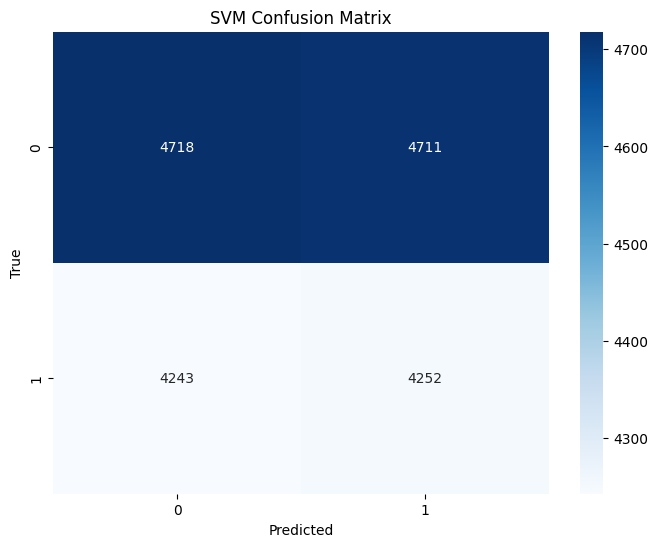

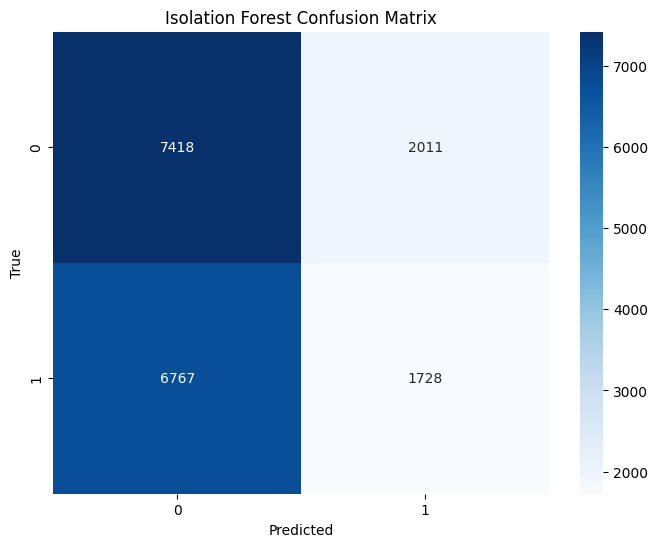

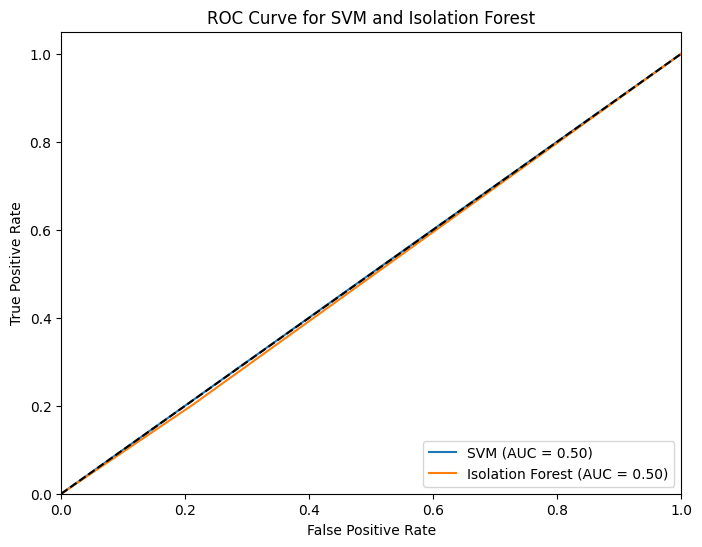

In [35]:
df['Anomaly'] = df['Anomaly'].astype(int)

svm_conf_matrix = confusion_matrix(df['Anomaly'], df['SVM_Anomaly'])
plt.figure(figsize=(8, 6))
plt.title('SVM Confusion Matrix')
sns.heatmap(svm_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

if_conf_matrix = confusion_matrix(df['Anomaly'], df['Isolation_Forest_Anomaly'])
plt.figure(figsize=(8, 6))
plt.title('Isolation Forest Confusion Matrix')
sns.heatmap(if_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# SVM ROC Curve
svm_roc_auc = roc_auc_score(df['Anomaly'], df['SVM_Anomaly'])
fpr_svm, tpr_svm, _ = roc_curve(df['Anomaly'], df['SVM_Anomaly'])

# Isolation Forest ROC Curve
if_roc_auc = roc_auc_score(df['Anomaly'], df['Isolation_Forest_Anomaly'])
fpr_if, tpr_if, _ = roc_curve(df['Anomaly'], df['Isolation_Forest_Anomaly'])

# Plotting both ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, label='SVM (AUC = %0.2f)' % svm_roc_auc)
plt.plot(fpr_if, tpr_if, label='Isolation Forest (AUC = %0.2f)' % if_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVM and Isolation Forest')
plt.legend(loc="lower right")
plt.show()


In [37]:
joblib.dump(svm_model, 'svm_model.pkl')
joblib.dump(isolation_forest_model, 'isolation_forest_model.pkl')

['isolation_forest_model.pkl']